In [1]:
import numpy as np
import pandas as pd
from functools import cache
from tqdm import tqdm

# Feature Engineering

In [2]:
batting_data = pd.read_parquet("data/batting_full.parquet.gz")
pitching_data = pd.read_parquet("data/pitching_full.parquet.gz")

## Batting


In [3]:
batting_cols = [
    # Meta
    "IDfg",
    "Season",
    "Team",
    "Age",
    # Normalization
    "AB",
    # Stats
    "OPS",  # TODO: how to get OPS+?
    "WAR",
    "OBP+",
    "2B",
    "3B",
    "HR",
    "CS",
    "SB",
    "SO",
    # Left-handed?
]
batting_cleaned = batting_data[batting_cols].dropna()
batting_cleaned = batting_cleaned[batting_cleaned["AB"] > 0]
# Normalize for at-bats
for col in ["OPS", "2B", "3B", "HR", "SO", "CS", "SB"]:
    batting_cleaned[col] /= batting_cleaned["AB"]
batting_cleaned.rename(columns={"AB": "weight"}, inplace=True)

In [4]:
batting_cleaned.head()

,IDfg,Season,Team,Age,weight,OPS,WAR,OBP+,2B,3B,HR,CS,SB,SO
0,1008559,1998,STL,34,509,0.002401,8.5,138.0,0.041257,0.000000,0.137525,0.000000,0.001965,0.304519
1,1109,1998,SFG,33,552,0.001897,8.5,129.0,0.079710,0.012681,0.067029,0.021739,0.050725,0.166667
2,1093,1998,NYM,29,557,0.001792,8.1,132.0,0.064632,0.007181,0.039497,0.003591,0.003591,0.131059
3,1274,1998,SEA,22,686,0.001340,7.9,106.0,0.051020,0.007289,0.061224,0.018950,0.067055,0.176385
4,190,1998,BOS,24,604,0.001566,7.3,106.0,0.061258,0.013245,0.057947,0.009934,0.019868,0.102649


In [5]:
# Save
batting_cleaned.to_parquet("data/batting_cleaned.parquet.gz", compression="gzip")

## Pitching


In [6]:
pitching_cols = [
    # Meta
    "IDfg",
    "Season",
    "Team",
    "Age",
    # Normalization
    "TBF",
    # Stats
    "ERA-",
    "H",
    "HR",
    "BB",
    "SO",
]

pitching_cleaned = pitching_data[pitching_cols].dropna()
pitching_cleaned = pitching_cleaned[pitching_cleaned["TBF"] > 0]
# Normalize for batters faced
for col in ["H", "HR", "BB", "SO"]:
    pitching_cleaned[col] /= pitching_cleaned["TBF"]
pitching_cleaned.rename(columns={"TBF": "weight"}, inplace=True)

In [7]:
pitching_cleaned.head()

,IDfg,Season,Team,Age,weight,ERA-,H,HR,BB,SO
0,642,1998,SDP,33,1032,60,0.218023,0.007752,0.047481,0.249031
1,73,1998,PHI,31,1089,76,0.216713,0.021120,0.056015,0.275482
2,815,1998,TOR,35,961,57,0.175858,0.011446,0.091571,0.281998
3,60,1998,- - -,34,1014,72,0.200197,0.022682,0.084813,0.324458
4,104,1998,ATL,32,987,53,0.203647,0.013171,0.045593,0.206687


In [8]:
#  Save
pitching_cleaned.to_parquet("data/pitching_cleaned.parquet.gz", compression="gzip")

## Schedule/Record


In [9]:
curr_teams = [
    "NYY",
    "KCR",
    "LAD",
    "BAL",
    "NYM",
    "BOS",
    "CLE",
    "CIN",
    "ARI",
    "TOR",
    "SFG",
    "MIL",
    "SEA",
    "HOU",
    "SDP",
    "PHI",
    "OAK",
    "ATL",
    "TEX",
    "MIN",
    "CHC",
    "DET",
    "COL",
    "STL",
    "PIT",
    "LAA",
    "WSN",
    "MIA",
    "TBR",
    "CHW",
]

renames = {
    "ANA": "LAA",
    "FLA": "MIA",
    "MON": "WSN",
    "TBD": "TBR",
}

In [10]:
schedules = pd.read_parquet("data/schedules_full.parquet.gz")

In [11]:
schedules.head()

,Date,Tm,Home_Away,Opp,W/L,R,RA,Inn,W-L,Rank,...,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,Season
0,"Wednesday, Apr 1",NYY,@,ANA,L,1.0,4.0,9.0,0-1,5.0,...,Finley,Pettitte,Percival,2:52,N,43311.0,1.00,-1.0,None,1998
1,"Thursday, Apr 2",NYY,@,ANA,L,2.0,10.0,9.0,0-2,5.0,...,Hill,Wells,None,3:19,N,29899.0,.95,-2.0,None,1998
2,"Saturday, Apr 4",NYY,@,OAK,L,3.0,7.0,9.0,0-3,5.0,...,Haynes,Cone,None,2:57,D,17118.0,.93,-3.0,None,1998
3,"Sunday, Apr 5",NYY,@,OAK,W,9.0,7.0,10.0,1-3,5.0,...,Nelson,Mohler,None,4:15,D,18109.0,.84,1.0,None,1998
4,"Monday, Apr 6",NYY,@,SEA,L,0.0,8.0,9.0,1-4,5.0,...,Moyer,Pettitte,None,3:08,N,27445.0,.88,-1.0,None,1998


In [12]:
def add_momentum_columns(df, prefix):
    # Remove win/loss of current game from season record to prevent data leakage
    won = df["W/L"].apply(lambda x: 1 if x == "W" else 0)
    lost = df["W/L"].apply(lambda x: 1 if x == "L" else 0)
    season_wins = df["W-L"].str.split("-").str[0].astype(int) - won
    season_losses = df["W-L"].str.split("-").str[1].astype(int) - lost

    df[prefix + "_wins_pct"] = (season_wins / (season_wins + season_losses)).fillna(0.5)
    df.drop(columns=["W/L", "W-L"], inplace=True)

In [13]:
# Get rid of data leakage in streak
def fix_streaks(df):
    for season in df.Season.unique():
        season_df = df[df.Season == season]
        for team in season_df.HomeTeam.unique():
            # Filter rows for the current team
            team_indices = (df.Season == season) & (df.HomeTeam == team)
            team_df = df.loc[team_indices]

            # Roll streaks forward
            df.loc[team_indices, "Streak"] = team_df.Streak.shift(1)

    # Fill NaN values with 0
    df.Streak.fillna(0, inplace=True)

In [14]:
schedules_cleaned = schedules[
    ["Tm", "Opp", "W/L", "W-L", "D/N", "Home_Away", "Season", "Date", "Streak"]
].copy()
# Rename columns
schedules_cleaned.rename(columns={"Tm": "HomeTeam", "Opp": "AwayTeam"}, inplace=True)
# Rename Teams: TODO: figure out why this isn't working
# schedules_cleaned["Tm"] = schedules_cleaned["Tm"].replace(renames)
# schedules_cleaned["Opp"] = schedules_cleaned["Opp"].replace(renames)
# Drop non-current teams
schedules_cleaned = schedules_cleaned[
    schedules_cleaned["HomeTeam"].isin(curr_teams)
    & schedules_cleaned["AwayTeam"].isin(curr_teams)
]
# Drop pre-1999
schedules_cleaned = schedules_cleaned[schedules_cleaned["Season"] > 1998]
# Drop ties
schedules_cleaned = schedules_cleaned[schedules_cleaned["W/L"] != "T"]
# Roll streak forward to avoid data leakage
fix_streaks(schedules_cleaned)

# Add dummies
schedules_cleaned["Day"] = schedules_cleaned["D/N"].str.contains("D").astype(int)
schedules_cleaned["Win"] = schedules_cleaned["W/L"].str.contains("W").astype(int)

# Add momentum columns + drop home games
home_mask = schedules_cleaned["Home_Away"] == "Home"
away_games = schedules_cleaned[~home_mask].copy()
home_games = schedules_cleaned[home_mask].copy()
add_momentum_columns(away_games, "away")
add_momentum_columns(home_games, "home")

In [15]:
away_games.head()

,HomeTeam,AwayTeam,D/N,Home_Away,Season,Date,Streak,Day,Win,away_wins_pct
4216,NYY,OAK,N,@,1999,"Monday, Apr 5",0.0,0,0,0.500000
4217,NYY,OAK,N,@,1999,"Tuesday, Apr 6",-1.0,0,1,0.000000
4218,NYY,OAK,D,@,1999,"Wednesday, Apr 7",1.0,1,1,0.500000
4225,NYY,DET,N,@,1999,"Friday, Apr 16",-1.0,0,0,0.777778
4226,NYY,DET,D,@,1999,"Saturday, Apr 17",-2.0,1,0,0.700000


In [16]:
# # Merge home and away games
schedules_cleaned = pd.merge(
    home_games,
    away_games,
    left_on=["Date", "Season", "HomeTeam"],
    right_on=["Date", "Season", "AwayTeam"],
    suffixes=(None, "_away"),
    validate="1:1",
)
schedules_cleaned.rename(
    columns={"Streak": "home_streak", "Streak_away": "away_streak"}, inplace=True
)
schedules_cleaned.drop(
    columns=schedules_cleaned.columns[schedules_cleaned.columns.str.endswith("_away")],
    inplace=True,
)
schedules_cleaned.drop(columns=["D/N", "Home_Away"], inplace=True)

In [17]:
schedules_cleaned.head(20)

,HomeTeam,AwayTeam,Season,Date,home_streak,Day,Win,home_wins_pct,away_streak,away_wins_pct
0,NYY,DET,1999,"Friday, Apr 9",2.0,1,1,0.666667,-2.0,0.333333
1,NYY,DET,1999,"Saturday, Apr 10",3.0,1,1,0.750000,-3.0,0.250000
2,NYY,DET,1999,"Sunday, Apr 11",4.0,1,1,0.800000,-4.0,0.200000
3,NYY,BAL,1999,"Tuesday, Apr 13",5.0,0,1,0.833333,-1.0,0.333333
4,NYY,BAL,1999,"Wednesday, Apr 14",6.0,0,1,0.857143,-2.0,0.285714
5,NYY,BAL,1999,"Thursday, Apr 15",7.0,0,0,0.875000,-3.0,0.250000
6,NYY,TEX,1999,"Tuesday, Apr 20",-4.0,0,1,0.583333,1.0,0.538462
7,NYY,TEX,1999,"Wednesday, Apr 21",1.0,0,1,0.615385,-1.0,0.500000
8,NYY,TOR,1999,"Friday, Apr 23",2.0,0,1,0.642857,5.0,0.750000
9,NYY,TOR,1999,"Saturday, Apr 24",3.0,1,1,0.666667,-1.0,0.705882


In [18]:
assert schedules_cleaned.isna().sum().sum() == 0
schedules_cleaned.to_parquet("data/schedules_cleaned.parquet.gz", compression="gzip")
schedules_cleaned.head()

,HomeTeam,AwayTeam,Season,Date,home_streak,Day,Win,home_wins_pct,away_streak,away_wins_pct
0,NYY,DET,1999,"Friday, Apr 9",2.0,1,1,0.666667,-2.0,0.333333
1,NYY,DET,1999,"Saturday, Apr 10",3.0,1,1,0.750000,-3.0,0.250000
2,NYY,DET,1999,"Sunday, Apr 11",4.0,1,1,0.800000,-4.0,0.200000
3,NYY,BAL,1999,"Tuesday, Apr 13",5.0,0,1,0.833333,-1.0,0.333333
4,NYY,BAL,1999,"Wednesday, Apr 14",6.0,0,1,0.857143,-2.0,0.285714


## Add Player Features to Schedules


In [19]:
@cache
def get_players(Team, Season):
    batting = batting_cleaned[
        (batting_cleaned["Team"] == Team) & (batting_cleaned["Season"] == Season)
    ]["IDfg"].unique()
    pitching = pitching_cleaned[
        (pitching_cleaned["Team"] == Team) & (pitching_cleaned["Season"] == Season)
    ]["IDfg"].unique()
    return batting, pitching

In [20]:
@cache
def get_team_stats(Team, Season):
    batting_players, pitching_players = get_players(Team, Season)
    if len(batting_players) == 0 or len(pitching_players) == 0:
        raise ValueError("No players", Team, Season)
    agg = {}

    # BATTING
    prior_season_batting = []
    batting_rookies = 0
    for player in batting_players:
        player_data = batting_cleaned[
            (batting_cleaned["IDfg"] == player)
            & (batting_cleaned["Season"] == Season - 1)
        ]
        if len(player_data) == 0:
            batting_rookies += 1
        else:
            prior_season_batting.append(player_data)
    if len(prior_season_batting) == 0:
        raise ValueError("No prior season batting data", Team, Season)

    batting_data = pd.concat(prior_season_batting)
    batting_data.drop(columns=["IDfg", "Season", "Team"], inplace=True)
    for col in batting_data.columns:
        if col == "weight":
            continue
        weights = batting_data["weight"].to_numpy()
        weighted_mean = np.average(batting_data[col], weights=weights)
        agg[f"batting_{col}_mean"] = weighted_mean
        # Bessel's correction for unbiased weighted sample variance
        agg[f"batting_{col}_var"] = np.sum(
            weights * (batting_data[col] - weighted_mean) ** 2
        ) / (np.sum(weights) - 1)
    agg["batting_rookies"] = batting_rookies

    # PITCHING
    prior_season_pitching = []
    pitching_rookies = 0
    for player in pitching_players:
        player_data = pitching_cleaned[
            (pitching_cleaned["IDfg"] == player)
            & (pitching_cleaned["Season"] == Season - 1)
        ]
        if len(player_data) == 0:
            pitching_rookies += 1
        else:
            prior_season_pitching.append(player_data)
    if len(prior_season_pitching) == 0:
        raise ValueError("No prior season pitching data", Team, Season)

    pitching_data = pd.concat(prior_season_pitching)
    pitching_data.drop(columns=["IDfg", "Season", "Team"], inplace=True)
    for col in pitching_data.columns:
        if col == "weight":
            continue
        weights = pitching_data["weight"].to_numpy()
        weighted_mean = np.average(pitching_data[col], weights=weights)
        agg[f"pitching_{col}_mean"] = weighted_mean
        # Bessel's correction for unbiased weighted sample variance
        agg[f"pitching_{col}_var"] = np.sum(
            weights * (pitching_data[col] - weighted_mean) ** 2
        ) / (np.sum(weights) - 1)
    agg["pitching_rookies"] = pitching_rookies

    return agg


In [21]:
new_features = []
for i, row in tqdm(schedules_cleaned.iterrows(), total=len(schedules_cleaned)):
    home_team = row["HomeTeam"]
    away_team = row["AwayTeam"]
    season = row["Season"]
    features = {}
    home_stats = get_team_stats(home_team, season)
    for key, value in home_stats.items():
        if np.isnan(value):
            print(home_team, season, key)
        features[f"home_{key}"] = value
    away_stats = get_team_stats(away_team, season)
    for key, value in away_stats.items():
        if np.isnan(value):
            print(away_team, season, key)
        features[f"away_{key}"] = value
    new_features.append(features)
new_features = pd.DataFrame(new_features)

100%|██████████| 56347/56347 [00:16<00:00, 3462.64it/s]


In [22]:
final_data = pd.concat(
    [schedules_cleaned.reset_index(drop=True), new_features.reset_index(drop=True)],
    axis=1,
)
assert final_data.isna().sum().sum() == 0
final_data.to_parquet("data/final_data.parquet.gz", compression="gzip")
final_data.head()

,HomeTeam,AwayTeam,Season,Date,home_streak,Day,Win,home_wins_pct,away_streak,away_wins_pct,...,away_pitching_ERA-_var,away_pitching_H_mean,away_pitching_H_var,away_pitching_HR_mean,away_pitching_HR_var,away_pitching_BB_mean,away_pitching_BB_var,away_pitching_SO_mean,away_pitching_SO_var,away_pitching_rookies
0,NYY,DET,1999,"Friday, Apr 9",2.0,1,1,0.666667,-2.0,0.333333,...,270.105447,0.231144,0.000500,0.027963,0.000128,0.087224,0.000674,0.159312,0.00114,8
1,NYY,DET,1999,"Saturday, Apr 10",3.0,1,1,0.750000,-3.0,0.250000,...,270.105447,0.231144,0.000500,0.027963,0.000128,0.087224,0.000674,0.159312,0.00114,8
2,NYY,DET,1999,"Sunday, Apr 11",4.0,1,1,0.800000,-4.0,0.200000,...,270.105447,0.231144,0.000500,0.027963,0.000128,0.087224,0.000674,0.159312,0.00114,8
3,NYY,BAL,1999,"Tuesday, Apr 13",5.0,0,1,0.833333,-1.0,0.333333,...,480.827063,0.245114,0.000671,0.024324,0.000025,0.075676,0.000484,0.169439,0.00182,4
4,NYY,BAL,1999,"Wednesday, Apr 14",6.0,0,1,0.857143,-2.0,0.285714,...,480.827063,0.245114,0.000671,0.024324,0.000025,0.075676,0.000484,0.169439,0.00182,4


# Model Selection + Training

In [23]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

plt.rcParams["figure.dpi"] = 300

In [24]:
def best_accuracy(y_true, y_prob):
    best_acc = 0
    best_threshold = 0
    for threshold in np.linspace(0, 1, 100):
        y_pred = y_prob > threshold
        acc = accuracy_score(y_true, y_pred)
        if acc > best_acc:
            best_acc = acc
            best_threshold = threshold
    return best_acc, best_threshold

In [25]:
seasons = final_data.Season.unique()
train_seasons, test_seasons = train_test_split(seasons, test_size=0.2)
train_mask = final_data.Season.isin(train_seasons)
X = final_data.drop(columns=["HomeTeam", "AwayTeam", "Season", "Win", "Date"]).copy()
y = final_data.Win

X_train = X[train_mask]
X_test = X[~train_mask]
y_train = y[train_mask]
y_test = y[~train_mask]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_error: 0.439763


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

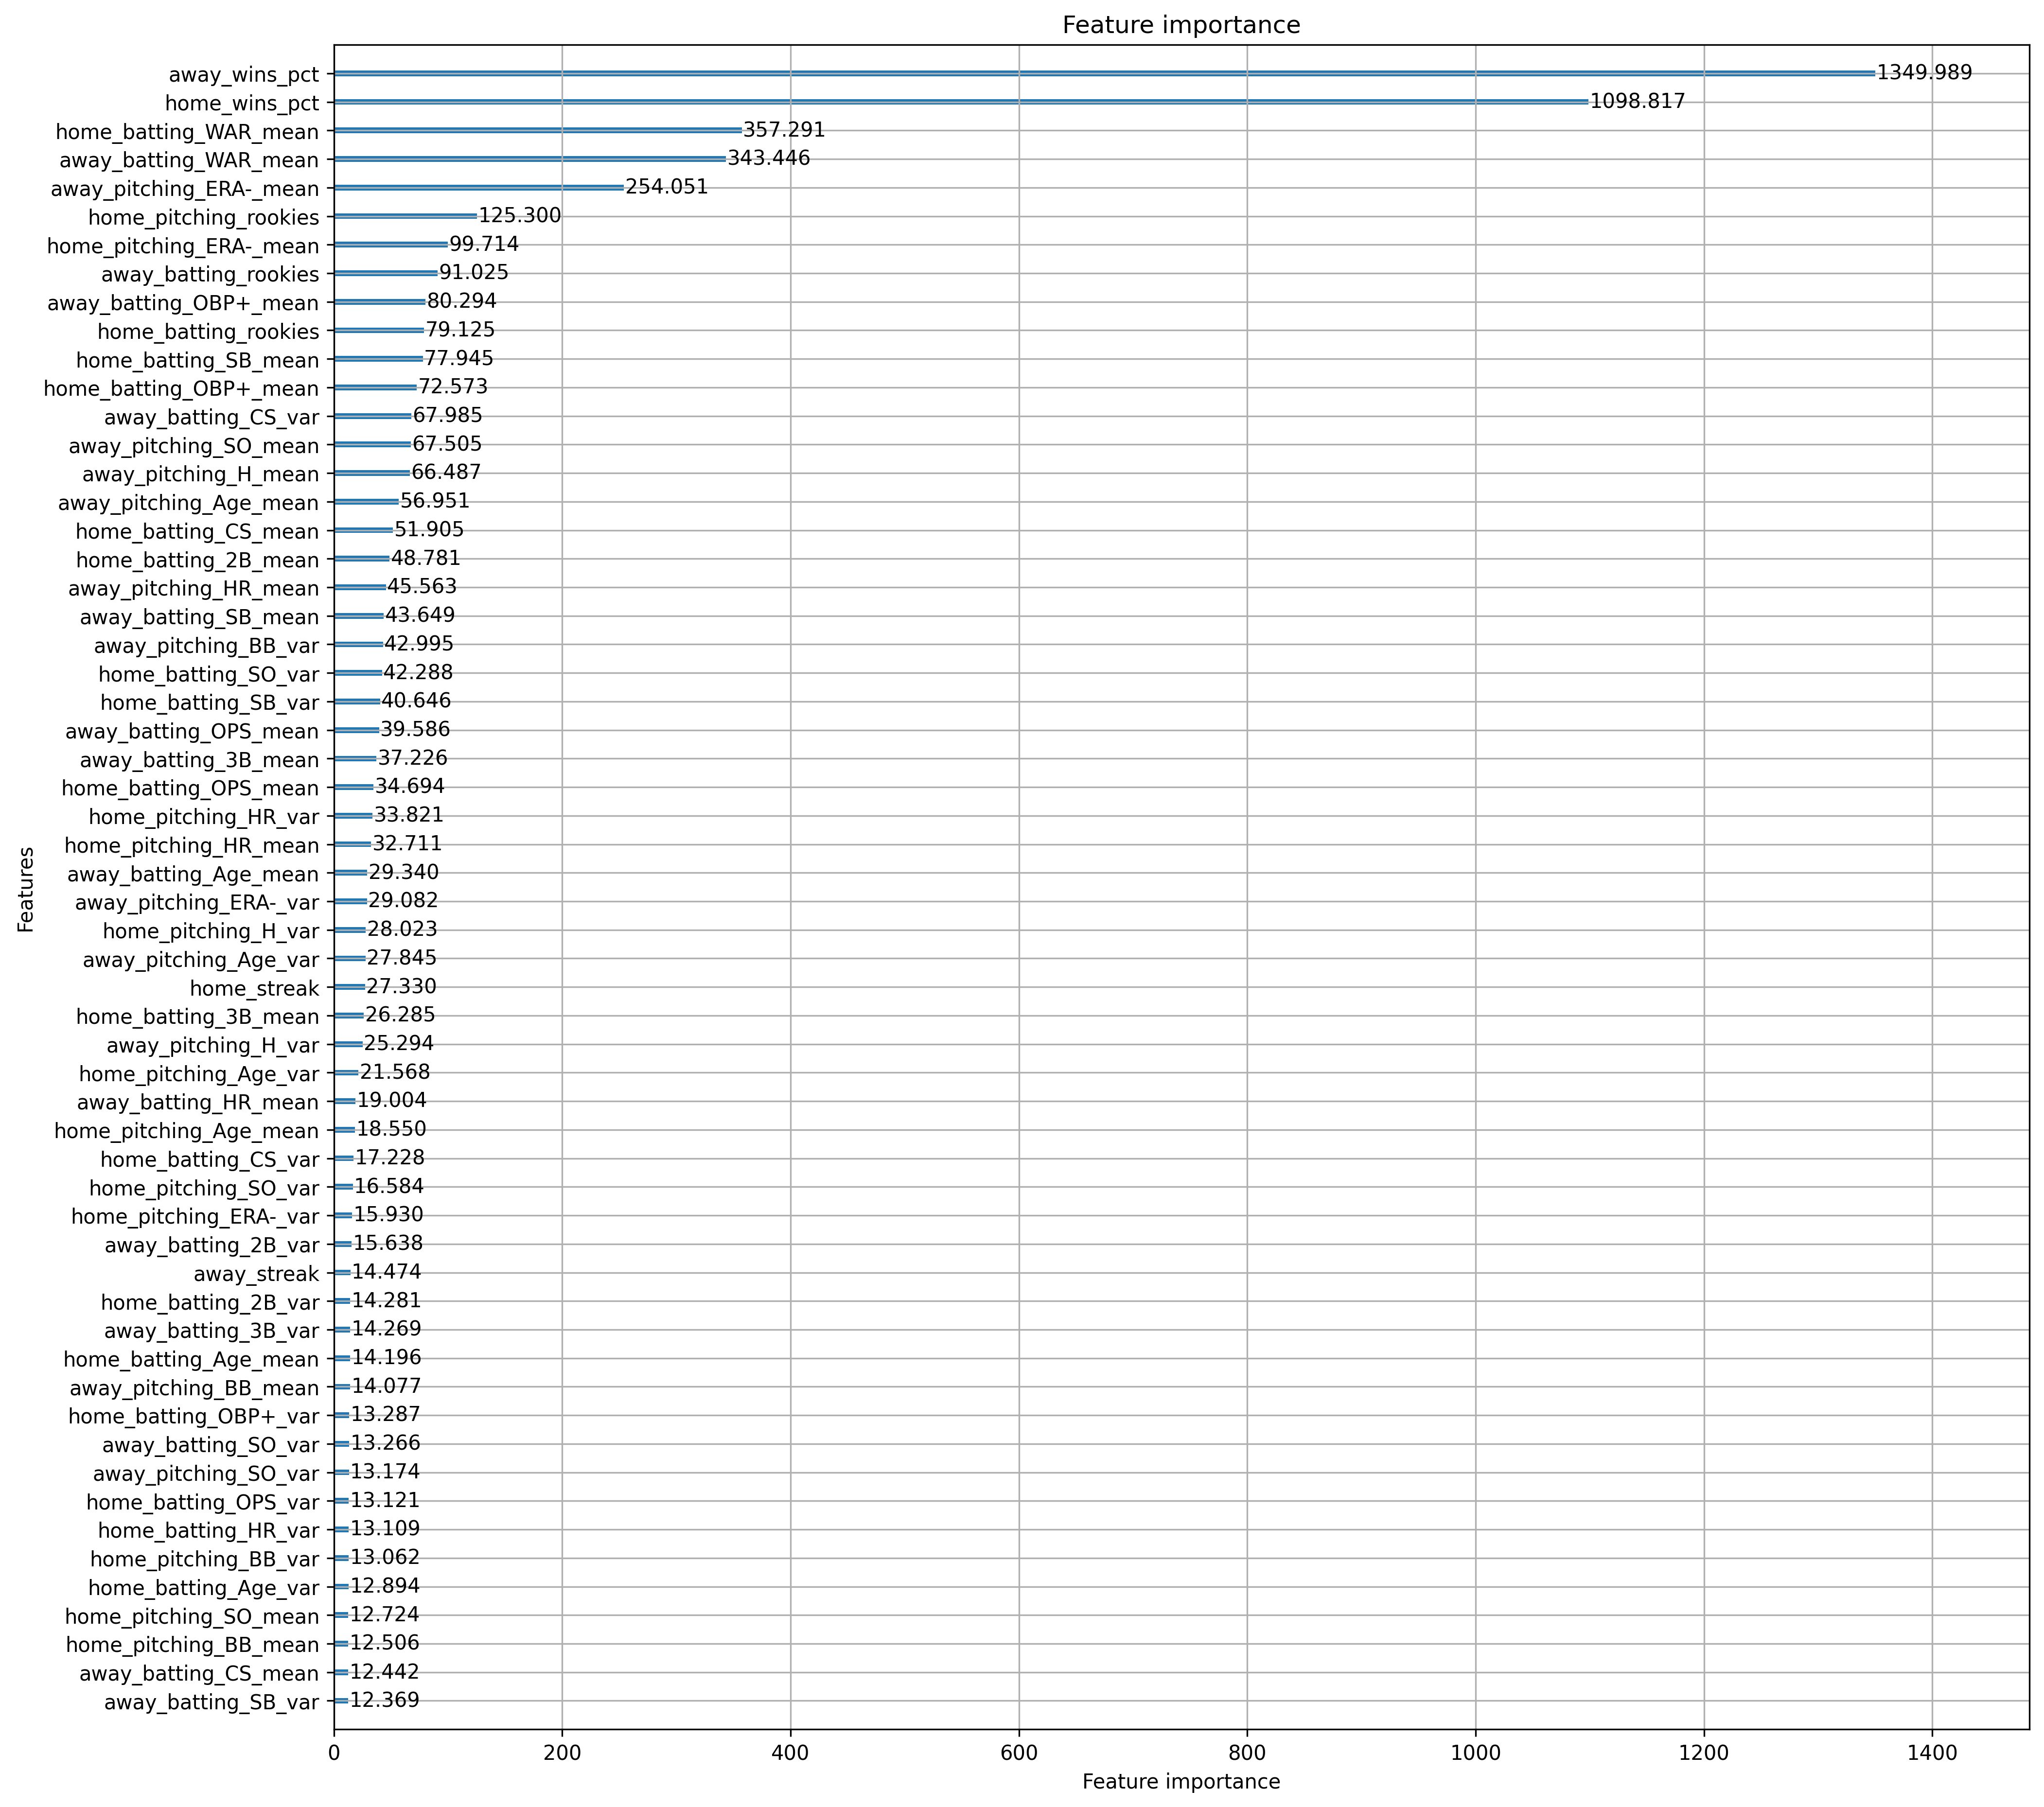

In [26]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

lgb_model = lgb.train(
    {
        "objective": "binary",
        "metric": "binary_error",
        "verbosity": -1,
    },
    lgb_train,
    num_boost_round=1000,
    valid_sets=lgb_test,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

lgb.plot_importance(lgb_model, importance_type="gain", figsize=(15, 15))

In [27]:
# LGB Accuracy
acc, thres = best_accuracy(y_test, lgb_model.predict(X_test))
print(f"LGBM Accuracy: {acc*100:.2f}%, with {thres:.2f} threshold")

LGBM Accuracy: 55.85%, with 0.51 threshold


In [28]:
log_reg = make_pipeline(
    SimpleImputer(strategy="mean"),
    StandardScaler(),
    LogisticRegression(random_state=0),
)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(f"Logistic Regression R^2: {r2:.2f}")
print(f"Logistic Regression Accuracy: {acc*100:.2f}%")

Logistic Regression R^2: -0.77
Logistic Regression Accuracy: 56.11%


In [46]:
# Matthew's Epic Model
p = y_train.mean()

# Bernoulli with len(y_test) trials
n = len(y_test)
bernoulli = np.random.binomial(1, p, size=n)

accuracy_score(y_test, bernoulli)

0.5069097075031793

In [57]:
# Matthew's Epic-er model

y_pred = []
for p in X_test.home_wins_pct:
    y_pred.append(np.random.binomial(1, p))
accuracy_score(y_test, y_pred)

0.5172530733361594

In [ ]:
reg = make_pipeline(
    SimpleImputer(strategy="mean"),
    StandardScaler(),
    SVC(probability=True),
)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(f"SVC R^2: {r2:.2f}")

In [ ]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models